<a href="https://colab.research.google.com/github/umerrafiq04/CNN/blob/main/Mask_Vs_WithoutMask/Pretrained_MobileNetV2/FaceMask_Detection_CNN_Pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")
print("Dataset path:", path)


Using Colab cache for faster access to the 'face-mask-dataset' dataset.
Dataset path: /kaggle/input/face-mask-dataset


In [ ]:
import os

KAGGLE_PATH ="/kaggle/input/face-mask-dataset/data"
print(os.listdir(KAGGLE_PATH))


['without_mask', 'with_mask']


In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    KAGGLE_PATH,
    validation_split=0.2,      # 80% train, 20% val
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    KAGGLE_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)


Found 7553 files belonging to 2 classes.
Using 6043 files for training.
Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


In [ ]:
class_names = train_ds.class_names
print("Classes:", class_names)


Classes: ['with_mask', 'without_mask']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())


Train batches: 189
Val batches: 48


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Pretrained MobileNetV2 as base model
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # freeze weights initially

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 46s 173ms/step - accuracy: 0.6938 - loss: 0.6389 - val_accuracy: 0.8735 - val_loss: 0.3121
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8580 - loss: 0.3354 - val_accuracy: 0.8848 - val_loss: 0.2786
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8658 - loss: 0.3077 - val_accuracy: 0.8954 - val_loss: 0.2583
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8825 - loss: 0.2822 - val_accuracy: 0.8974 - val_loss: 0.2469
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8784 - loss: 0.2772 - val_accuracy: 0.8993 - val_loss: 0.2431
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8877 - loss: 0.2667 - val_accuracy: 0.8993 - val_loss: 0.2339
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8868 - loss: 0.2647 - val_accuracy: 0.8987 - val_loss: 0.2396
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8914 - loss: 0.2569 - val_ac

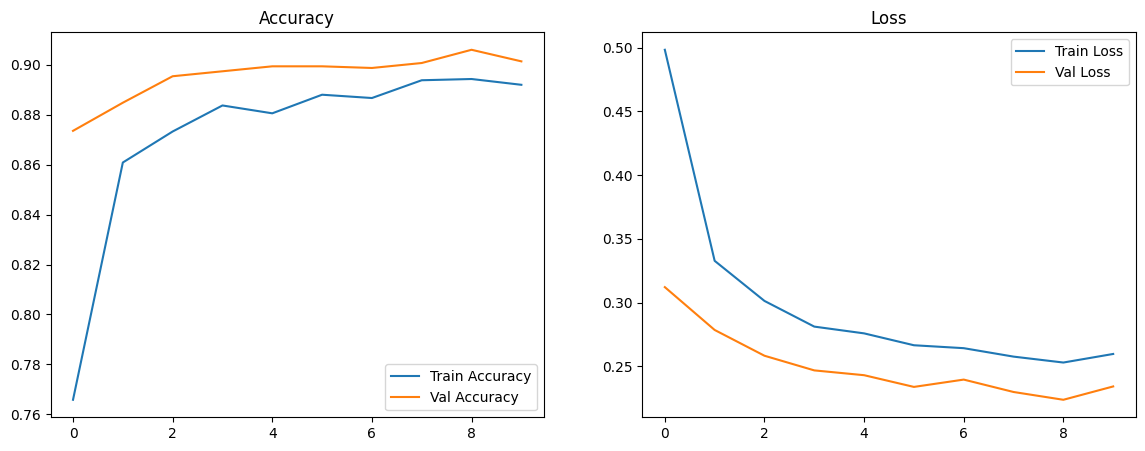

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving nomask.jpg to nomask.jpg


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

img_path = list(uploaded.keys())[0]

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)

# class_names = train_ds.class_names
print("Predicted:", class_names[np.argmax(pred)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted: without_mask


In [ ]:
"""
important

include_top=False

This removes the last classification layer of MobileNetV2.

Why?

Because MobileNetV2 originally predicts 1000 classes (ImageNet classes like dog, cat, bus, etc.)

But your dataset has only 2 classes:

with_mask

without_mask

So you don’t want the original final layer.
"""

In [ ]:
print("Training Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])


Training Accuracy: 0.8919410705566406
Validation Accuracy: 0.9013245105743408


In [ ]:
val_loss, val_acc = model.evaluate(val_ds)
print("Validation Accuracy:", val_acc)


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8963 - loss: 0.2368
Validation Accuracy: 0.9013245105743408
